In [13]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Research Agent with MCP

*The goal of research is to gather the context requested by the research brief.*

Here is our overall research flow:

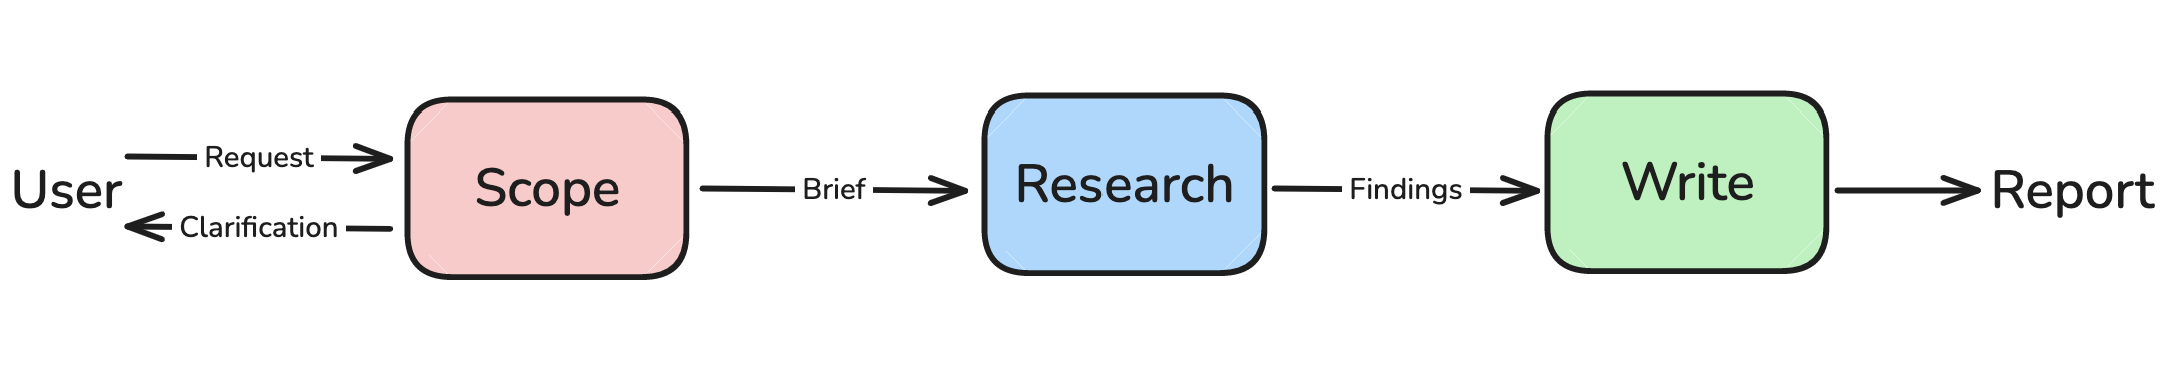

We built an [agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) that will a custom search tool. But, we can also use the [Model Context Protocol (MCP)](https://modelcontextprotocol.io/specification/2025-06-18/architecture) as another way to access tools! MCP servers provide a standard protocol for accessing tools. [LangChain MCP Adapters](https://github.com/langchain-ai/langchain-mcp-adapters) provide a seamless bridge between the Model Context Protocol (MCP) and LangChain/LangGraph ecosystems. This library enables compatibility between MCP servers and our LangGraph agent. 

Let's pick one example MCP server and see how it works! The [Filesystem MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) provides secure, controlled access to local file systems with granular permission management.

**What It Provides:**
- **File operations** with strict access control
- **Directory management** with dynamic permissions
- **Search capabilities** across allowed directories
- **Metadata access** for files and directories

**Available Tools:**
- **File Operations**: `read_file`, `write_file`, `edit_file`, `read_multiple_files`
- **Directory Management**: `create_directory`, `list_directory`, `move_file`
- **Search & Discovery**: `search_files`, `get_file_info`, `list_allowed_directories`

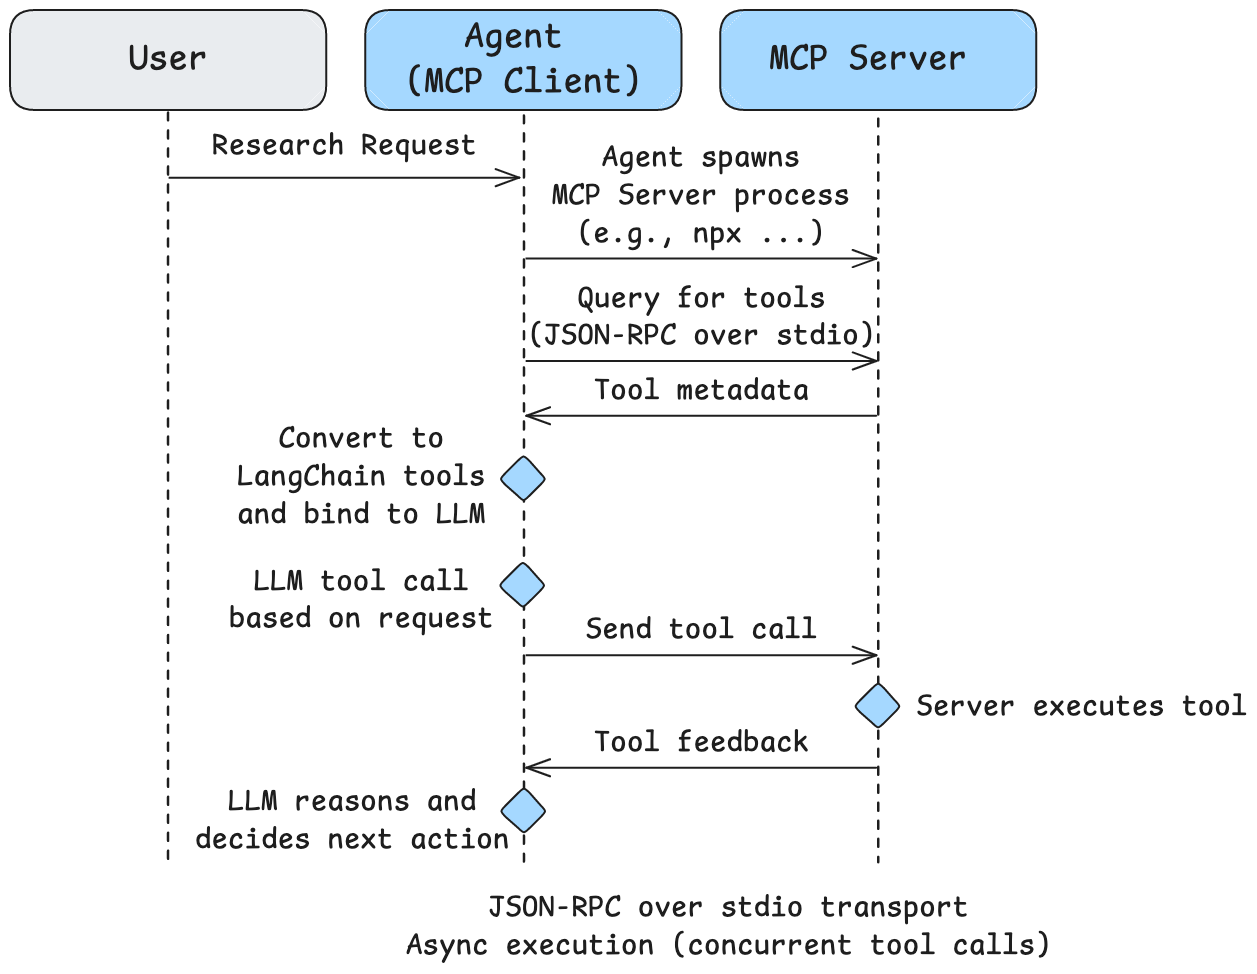

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [14]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp
show_prompt(research_agent_prompt_with_mcp, "Research Agent Instructions MCP")

╭──────────────────────────────────────── Research Agent Instructions MCP ────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic using local files. For context,     │
│  today's date is {date}.                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use file system tools to gather information from local research files.                          │
│  You can use any of the tools provided to you to find and read files that help answer the research question.    │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to file system tools and thinking tools:                                                       │
│  - **list_allowed_directories**: See what directories you can access                                            │
│  - **list_directory**: List files in directories                                                                │
│  - **read_file**: Read individual files                                                                         │
│  - **read_multiple_files**: Read multiple files at once                                                         │
│  - **search_files**: Find files containing specific content                                                     │
│  - **think_tool**: For reflection and strategic planning during research                                        │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after reading files to reflect on findings and plan next steps**                    │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with access to a document library. Follow these steps:                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Explore available files** - Use list_allowed_directories and list_directory to understand what's          │
│  available                                                                                                      │
│  3. **Identify relevant files** - Use search_files if needed to find documents matching the topic               │
│  4. **Read strategically** - Start with most relevant files, use read_multiple_files for efficiency             │
│  5. **After reading, pause and assess** - Do I have enough to answer? What's still missing?                     │
│  6. **Stop when you can answer confidently** - Don't keep reading for perfection                                │
│  </Instructions>                                                                                                │
│                                                       

### Research Tool

Now, we'll use the `Filesystem MCP Server` to access research tools.

When using MCP tools with LangChain, you must use async methods because the MCP protocol is inherently asynchronous:
- Server communication uses async JSON-RPC over stdio/http
- Tool invocations involve network/IPC calls that can be slow
- Async enables non-blocking, concurrent operations

With this in mind, LangChain MCP Adapters are designed for async-only operation:
- Tools are wrapped as async StructuredTools
- Sync invocation is intentionally not implemented
- This ensures consistent async behavior across all MCP tools

Async enables:
- Concurrent tool execution
- Non-blocking server communication
- Better resource utilization
- Responsive applications

MCP servers run as subprocesses:
- Communication happens over pipes (stdin/stdout)
- These I/O operations are naturally async
- Blocking sync calls would freeze the entire process


In [15]:
# Simple MCP Example
import os
from langchain_mcp_adapters.client import MultiServerMCPClient
from rich.console import Console
from rich.panel import Panel
from rich.table import Table

console = Console()

# Get the absolute path to our sample research docs
sample_docs_path = os.path.abspath("./files/")
console.print(f"[bold blue]Sample docs path:[/bold blue] {sample_docs_path}")

# Check if the directory exists
if os.path.exists(sample_docs_path):
    console.print(f"[green]✓ Directory exists with files:[/green] {os.listdir(sample_docs_path)}")
else:
    console.print("[red]✗ Directory does not exist![/red]")

# MCP Client configuration - filesystem server for local document access
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # Auto-install if needed
            "@modelcontextprotocol/server-filesystem",
            sample_docs_path
        ],
        "transport": "stdio"
    }
}

console.print(Panel("[bold yellow]Creating MCP client...[/bold yellow]", expand=False))
client = MultiServerMCPClient(mcp_config)
console.print("[green]✓ MCP client created successfully![/green]")

# Test getting tools
console.print(Panel("[bold yellow]Getting tools...[/bold yellow]", expand=False))
tools = await client.get_tools()

# Create a rich table for tool display
table = Table(title="Available MCP Tools", show_header=True, header_style="bold magenta")
table.add_column("Tool Name", style="cyan", width=25)
table.add_column("Description", style="white", width=80)

for tool in tools:
    # Truncate long descriptions for better display
    description = tool.description[:77] + "..." if len(tool.description) > 80 else tool.description
    table.add_row(tool.name, description)

console.print(table)
console.print(f"[bold green]✓ Successfully retrieved {len(tools)} tools from MCP server[/bold green]")

Sample docs path: /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files

✓ Directory exists with files: ['coffee_shops_sf.md']

╭────────────────────────╮
│ Creating MCP client... │
╰────────────────────────╯

✓ MCP client created successfully!

╭──────────────────╮
│ Getting tools... │
╰──────────────────╯

                                              Available MCP Tools                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool Name                 ┃ Description                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ read_file                 │ Read the complete contents of a file as text. DEPRECATED: Use read_text_file ... │
│ read_text_file            │ Read the complete contents of a file from the file system as text. Handles va... │
│ read_media_file           │ Read an image or audio file. Returns the base64 encoded data and MIME type. O... │
│ read_multiple_files       │ Read the contents of multiple files simultaneously. This is more efficient th... │
│ write_file                │ Create a new file or completely overwrite an existing file with new content. ... │
│ edit_file                 │ Make line-based edits to a text file. Each edit replaces exact line sequences... │
│ create_directory          │ Create a new directory or ensure a directory exists. Can create multiple nest... │
│ list_directory            │ Get a detailed listing of all files and directories in a specified path. Resu... │
│ list_directory_with_sizes │ Get a detailed listing of all files and directories in a specified path, incl... │
│ directory_tree            │ Get a recursive tree view of files and directories as a JSON structure. Each ... │
│ move_file                 │ Move or rename files and directories. Can move files between directories and ... │
│ search_files              │ Recursively search for files and directories matching a pattern. Searches thr... │
│ get_file_info             │ Retrieve detailed metadata about a file or directory. Returns comprehensive i... │
│ list_allowed_directories  │ Returns the list of root directories that this server is allowed to access. U... │
└───────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┘

✓ Successfully retrieved 14 tools from MCP server

### Agent

Now, we'll define our agent again. But, we'll include the MCP server! 

The Model Context Protocol (MCP) is fundamentally designed around asynchronous operations, and this requirement is unavoidable due to several architectural factors:

MCP servers run as separate subprocesses that communicate via:
- **stdin/stdout pipes** (for local servers)
- **HTTP/WebSocket connections** (for remote servers)

Tool operations often involve:
- File system operations (reading, writing, searching)
- Network requests (for remote MCP servers)
- Database queries (for data-backed servers)
- External API calls

These operations have variable latency and benefit from non-blocking async execution.

In [16]:
%%writefile ../src/deep_research_from_scratch/research_agent_mcp.py

"""Research Agent with MCP Integration.

This module implements a research agent that integrates with Model Context Protocol (MCP)
servers to access tools and resources. The agent demonstrates how to use MCP filesystem
server for local document research and analysis.

Key features:
- MCP server integration for tool access
- Async operations for concurrent tool execution (required by MCP protocol)
- Filesystem operations for local document research
- Secure directory access with permission checking
- Research compression for efficient processing
- Lazy MCP client initialization for LangGraph Platform compatibility
"""

import os

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp, compress_research_system_prompt, compress_research_human_message
from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import get_today_str, think_tool, get_current_dir

# ===== CONFIGURATION =====

# MCP server configuration for filesystem access
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # Auto-install if needed
            "@modelcontextprotocol/server-filesystem",
            str(get_current_dir() / "files")  # Path to research documents
        ],
        "transport": "stdio"  # Communication via stdin/stdout
    }
}

# Global client variable - will be initialized lazily
_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

# Initialize models
compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000)
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")

# ===== AGENT NODES =====

async def llm_call(state: ResearcherState):
    """Analyze current state and decide on tool usage with MCP integration.

    This node:
    1. Retrieves available tools from MCP server
    2. Binds tools to the language model
    3. Processes user input and decides on tool usage

    Returns updated state with model response.
    """
    # Get available tools from MCP server
    client = get_mcp_client()
    mcp_tools = await client.get_tools()

    # Use MCP tools for local document access
    tools = mcp_tools + [think_tool]

    # Initialize model with tool binding
    model_with_tools = model.bind_tools(tools)

    # Process user input with system prompt
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt_with_mcp.format(date=get_today_str()))] + state["researcher_messages"]
            )
        ]
    }

async def tool_node(state: ResearcherState):
    """Execute tool calls using MCP tools.

    This node:
    1. Retrieves current tool calls from the last message
    2. Executes all tool calls using async operations (required for MCP)
    3. Returns formatted tool results

    Note: MCP requires async operations due to inter-process communication
    with the MCP server subprocess. This is unavoidable.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls

    async def execute_tools():
        """Execute all tool calls. MCP tools require async execution."""
        # Get fresh tool references from MCP server
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools + [think_tool]
        tools_by_name = {tool.name: tool for tool in tools}

        # Execute tool calls (sequentially for reliability)
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool is sync, use regular invoke
                observation = tool.invoke(tool_call["args"])
            else:
                # MCP tools are async, use ainvoke
                observation = await tool.ainvoke(tool_call["args"])
            observations.append(observation)

        # Format results as tool messages
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.

    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for further processing or reporting.

    This function filters out think_tool calls and focuses on substantive
    file-based research content from MCP tools.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]

    response = compress_model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue with tool execution or compress research.

    Determines whether to continue with tool execution or compress research
    based on whether the LLM made tool calls.
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # Continue to tool execution if tools were called
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, compress research findings
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder_mcp = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder_mcp.add_node("llm_call", llm_call)
agent_builder_mcp.add_node("tool_node", tool_node)
agent_builder_mcp.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder_mcp.add_edge(START, "llm_call")
agent_builder_mcp.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",        # Continue to tool execution
        "compress_research": "compress_research",  # Compress research findings
    },
)
agent_builder_mcp.add_edge("tool_node", "llm_call")  # Loop back for more processing
agent_builder_mcp.add_edge("compress_research", END)

# Compile the agent
agent_mcp = agent_builder_mcp.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_mcp.py


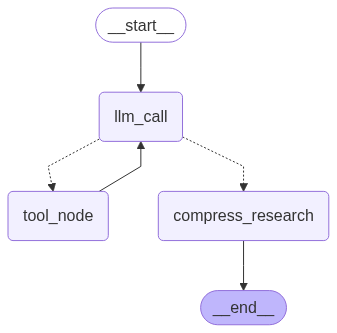

In [17]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent_mcp import agent_mcp

# Show the agent
display(Image(agent_mcp.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent_mcp.ainvoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the best coffee shops in San Francisco based on coffee quality. Let me start by          │
│ exploring what files are available and then systematically gather information from relevant sources.            │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│    ID: toolu_01N2uzUh8pGoXiPGhMJUGCix                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Allowed directories:                                                                                            │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files"             │
│ }                                                                                                               │
│    ID: toolu_01VdAt2acQYhpsserL5qid7S                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [FILE] coffee_shops_sf.md                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I found a file specifically about San Francisco coffee shops. Let me read this to see what information │
│ is available.                                                                                                   │
│                                                                                                                 │
│ 🔧 Tool Call: read_text_file                                                                                    │
│    Args: {                                                                                                      │
│   "path":                                                                                                       │
│ "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files/coffee_shops_sf.md"    │
│ }                                                                                                               │
│    ID: toolu_01Eu5rUQNPhHuDesAF6G4Crp                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # San Francisco Coffee Shops Research                                                                           │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Blue Bottle Coffee                                                                                          │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Specialty**: Single-origin coffee, pour-over methods                                                        │
│ - **Notable**: Known for freshly roasted beans, minimalist aesthetic                                            │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### Philz Coffee                                                                                                │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee, personalized service                                                    │
│ - **Notable**: Founded by Phil Jaber, known for unique blends like "Tesora"                                     │
│ - **Locations**: Original location in Mission District, now citywide                                            │
│                                                                                                                 │
│ ### Sightglass Coffee                                                                                           │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee, roasting transparency                                                       │
│ - **Notable**: Large roastery with viewing windows, industrial aesthetic                                        │
│ - **Location**: SOMA district flagship location                                                                 │
│                                                                                                                 │
│ ### Ritual Coffee Roasters                                                                                      │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships, seasonal offerings                                                 │
│ - **Notable**: Pioneer in San Francisco's third-wave coffee movement                                            │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### Four Barrel Coffee                                                                                          │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting, community focus                                                          │
│ - **Notable**: Known for Valencia Street location, local institution                                            │
│ - **Location**: Mission District                                                                                │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for any additional files that might contain more detailed information about coffee quality        │
│ assessments, reviews, or rankings.                                                                              │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files",            │
│   "pattern": "coffee quality"                                                                                   │
│ }                                                                                                               │
│    ID: toolu_016Y544VSWkLugdxGawQ465U                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files",            │
│   "pattern": "review"                                                                                           │
│ }                                                                                                               │
│    ID: toolu_01VuBxp2GA3kMVdnYhWiJXAX                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files",            │
│   "pattern": "rating"                                                                                           │
│ }                                                                                                               │
│    ID: toolu_01APLzfnn48yqFL9pmywn5L3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I've found one primary file about San Francisco coffee shops, which provides basic information │
│ about 5 notable coffee establishments: Blue Bottle Coffee, Philz Coffee, Sightglass Coffee, Ritual Coffee       │
│ Roasters, and Four Barrel Coffee. \n\nHowever, the current information is quite limited for the user's specific │
│ request. The file provides:\n- Basic founding information and specialties\n- General descriptions of each       │
│ shop's focus\n- Location information\n\nWhat's missing for a comprehensive coffee quality analysis:\n- Specific │
│ quality assessments or ratings\n- Expert reviews or certifications\n- Customer feedback about coffee quality\n- │
│ Comparative rankings based on coffee quality\n- Third-party review data from sources like Coffee Review, SCA,   │
│ Google, or Yelp\n- Current/recent data (the user specifically requested data as of July 2025)\n\nThe            │
│ information I have is quite basic and doesn't meet the user's specific criteria for evaluating coffee quality.  │
│ I should check if there are any other files that might contain more detailed quality assessments, reviews, or   │
│ ratings data. Let me do one more comprehensive search to see if there are any additional relevant files."       │
│ }                                                                                                               │
│    ID: toolu_01M4zyGeTTAGxcRikSvKaeu4                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I've found one primary file about San Francisco coffee shops, which provides basic         │
│ information about 5 notable coffee establishments: Blue Bottle Coffee, Philz Coffee, Sightglass Coffee, Ritual  │
│ Coffee Roasters, and Four Barrel Coffee.                                                                        │
│                                                                                                                 │
│ However, the current information is quite limited for the user's specific request. The file provides:           │
│ - Basic founding information and specialties                                                                    │
│ - General descriptions of each shop's focus                                                                     │
│ - Location information                                                                                          │
│                                                                                                                 │
│ What's missing for a comprehensive coffee quality analysis:                                                     │
│ - Specific quality assessments or ratings                                                                       │
│ - Expert reviews or certifications                                                                              │
│ - Customer feedback about coffee quality                                                                        │
│ - Comparative rankings based on coffee quality                                                                  │
│ - Third-party review data from sources like Coffee Review, SCA, Google, or Yelp                                 │
│ - Current/recent data (the user specifically requested data as of July 2025)                                    │
│                                                                                                                 │
│ The information I have is quite basic and doesn't meet the user's specific criteria for evaluating coffee       │
│ quality. I should check if there are any other files that might contain more detailed quality assessments,      │
│ reviews, or ratings data. Let me do one more comprehensive search to see if there are any additional relevant   │
│ files.                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: directory_tree                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/src/deep_research_from_scratch/files"             │
│ }                                                                                                               │
│    ID: toolu_012v1q7GnaVfKjZEvK8tEpU7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [                                                                                                               │
│   {                                                                                                             │
│     "name": "coffee_shops_sf.md",                                                                               │
│     "type": "file"                                                                                              │
│   }                                                                                                             │
│ ]                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research of the available files, I found limited information that doesn't fully meet your specific  │
│ requirements for evaluating San Francisco coffee shops based on coffee quality. Here's what I discovered:       │
│                                                                                                                 │
│ ## Available Information from Local Files                                                                       │
│                                                                                                                 │
│ I found one relevant file (`coffee_shops_sf.md`) containing basic information about 5 notable San Francisco     │
│ coffee shops:                                                                                                   │
│                                                                                                                 │
│ ### 1. **Blue Bottle Coffee** (Founded 2002)                                                                    │
│ - **Coffee Quality Focus**: Single-origin coffee, pour-over methods                                             │
│ - **Notable Quality Features**: Known for freshly roasted beans                                                 │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### 2. **Philz Coffee** (Founded 2003)                                                                          │
│ - **Coffee Quality Focus**: Custom blended coffee, personalized service                                         │
│ - **Notable Quality Features**: Unique proprietary blends like "Tesora"                                         │
│ - **Origin**: Founded in San Francisco (Mission District)                                                       │
│                                                                                                                 │
│ ### 3. **Sightglass Coffee** (Founded 2009)                                                                     │
│ - **Coffee Quality Focus**: Third-wave coffee movement, roasting transparency                                   │
│ - **Notable Quality Features**: Large roastery with viewing windows for transparency                            │
│ - **Location**: SOMA district flagship                                                                          │
│                                                                                                                 │
│ ### 4. **Ritual Coffee Roasters** (Founded 2005)                                                                │
│ - **Coffee Quality Focus**: Direct trade relationships, seasonal offerings                                      │
│ - **Notable Quality Features**: Pioneer in SF's third-wave coffee movement                                      │
│ - **Locations**: Multiple locations (Castro, Mission)                                                           │
│                                                                                                                 │
│ ### 5. **Four Barrel Coffee** (Founded 2008)                                                                    │
│ - **Coffee Quality Focus**: Small-batch roasting, community focus                                               │
│ - **Notable Quality Features**: Known for artisanal approach                                                    │
│ - **Location**: Mission District                                                                                │
│                                                                                                                 │
│ ## Research Limitations                                

We can see the trace [here](https://smith.langchain.com/public/3090174a-8ba2-4dec-9584-b2217678cbcc/r).

In [7]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 • Searched local file directory for files related to San Francisco coffee shops and coffee quality.               
 • Opened and inspected the file coffee_shops_sf.md.                                                               
 • Searched for files using keywords "coffee quality," "review," and "rating."                                     
 • Explored the directory tree for additional files.                                                               

Fully Comprehensive Findings                                                                                       

From the file coffee_shops_sf.md, the following information about notable San Francisco coffee shops was found:    

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                       San Francisco Coffee Shops Research                                       ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                         Top Coffee Shops in San Francisco                                         

                                                Blue Bottle Coffee                                                 

 • Founded: 2002 in Oakland, expanded to SF                                                                        
 • Specialty: Single-origin coffee, pour-over methods                                                              
 • Notable: Known for freshly roasted beans, minimalist aesthetic                                                  
 • Locations: Multiple SF locations including Ferry Building                                                       

                                                   Philz Coffee                                                    

 • Founded: 2003 in San Francisco                                                                                  
 • Specialty: Custom blended coffee, personalized service                                                          
 • Notable: Founded by Phil Jaber, known for unique blends like "Tesora"                                           
 • Locations: Original location in Mission District, now citywide                                                  

                                                 Sightglass Coffee                                                 

 • Founded: 2009                                                                                                   
 • Specialty: Third-wave coffee, roasting transparency                                                             
 • Notable: Large roastery with viewing windows, industrial aesthetic                                              
 • Location: SOMA district flagship location                                                                       

                                              Ritual Coffee Roasters                                               

 • Founded: 2005                                                                                                   
 • Specialty: Direct trade relationships, seasonal offerings                                                       
 • Notable: Pioneer in San Francisco's third-wave coffee movement                                                  
 • Locations: Multiple locations including Castro and Mission                                                      

                                                Four Barrel Coffee                                                 

 • Founded: 2008                                                                                                   
 • Specialty: Small-batch roasting, community focus                                                                
 • Notable: Known for Valencia Street lo

### What Just Happened? Let's Understand Each Component

#### The Client-Server Architecture

**Basic Client-Server Model:**
- **Client**: The `MultiServerMCPClient` acts as the client that requests services
- **Server**: The MCP server provides tools and executes operations
- **Communication**: They communicate using a standardized protocol (MCP)

```python
client = MultiServerMCPClient(mcp_config)
```

The `MultiServerMCPClient` is our LangChain MCP adapter client that:
- Starts MCP servers based on configuration
- Manages communication with one or more servers
- Converts MCP protocols to LangChain-compatible formats

#### `mcp_config` Dictionary and Transport Types

The configuration tells the MCP client how to start and connect to MCP servers:

```python
mcp_config = {
    "filesystem": {  # Server name (arbitrary label)
        "command": "npx",  # Command to run
        "args": ["-y", "@modelcontextprotocol/server-filesystem", "/path/to/docs"],
        "transport": "stdio"  # Communication method
    }
}
```

**Configuration Components:**
- **Server name** (`"filesystem"`): An arbitrary label for this server instance
- **Command** (`"npx"`): The command to execute to start the server
- **Args**: Command-line arguments passed to the server
- **Transport**: How the client communicates with the server

**Two Transport Types:**

1. **stdio Transport** (Local Servers):
   - Uses standard input/output for communication
   - Server runs as a subprocess on your local machine
   - Communication via pipes (stdin/stdout)
   - Example: `"transport": "stdio"`

2. **HTTP Transport** (Remote Servers):
   - Uses HTTP requests for communication
   - Server runs remotely on another machine/service
   - Communication via HTTP endpoints
   - Example: `"transport": "http"` with `"url": "https://api.example.com/mcp"`

**Remote MCP Servers:**
Remote MCP servers are third-party services that provide tools via HTTP. According to [Anthropic's documentation](https://docs.anthropic.com/en/docs/agents-and-tools/remote-mcp-servers):

- Companies like Asana, Cloudflare, PayPal, and Zapier offer remote MCP servers
- These use HTTP transport instead of stdio
- Typical URL format: `https://mcp.[company-name].com/sse`
- Require authentication credentials and trust verification

**Example Remote Configuration:**
```python
mcp_config = {
    "remote_service": {
        "url": "https://mcp.example.com/sse",
        "transport": "http",
        "headers": {
            "Authorization": "Bearer your-token-here"
        }
    }
}
```

#### The Server

When using stdio transport (local servers):
- Client `MultiServerMCPClient(mcp_config)` starts the server as a subprocess
- Server is a Node.js process running on your local machine
- It runs: `npx @modelcontextprotocol/server-filesystem /path/to/docs`
- The server process runs as long as the client is active
- **Verified**: Yes, the client starts and manages the server process lifecycle

When using HTTP transport (remote servers):
- Client connects to an existing remote server
- No subprocess is started locally
- Server runs independently on remote infrastructure
- Communication happens over HTTP/HTTPS

#### Tool Binding

Within the agent, MCP client queries the server for tools:
```python
tools = await client.get_tools()
```

**The Process:**
1. MCP client queries each server: "What tools do you provide?"
2. Server responds with tool metadata: Name, description, parameters, types
3. The MCP client (adapter) converts tool metadata to LangChain format
4. This makes them compatible with LangChain agents
5. We bind the tools to the model as usual:
```python
model_with_tools = model.bind_tools(tools)
```

#### Tool Execution

When the LLM calls a tool:
1. **LLM Decision**: The LLM decides which tools to use based on the user's request
2. **Client Forwarding**: The client forwards the request to the appropriate server
3. **Communication**: 
   - **stdio**: Via STDIN (for local servers)
   - **HTTP**: Via HTTP requests (for remote servers)
4. **Server Execution**: The server executes the operation (e.g., reads a file)
5. **Async Processing**: This is done asynchronously for performance
6. **Response**: Server sends responses back to the client
   - **stdio**: Via STDOUT (for local servers)
   - **HTTP**: Via HTTP responses (for remote servers)
7. **Protocol**: All communication uses MCP protocol format (JSON-RPC)

```python
coros.append(tool.ainvoke(tool_call["args"]))
```

**Key Differences:**
- **Local (stdio)**: Fast, secure, requires server installation
- **Remote (HTTP)**: Slower, requires trust/auth, no local installation needed

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_mcp` in the dropdown menu:

```
"research_agent_mcp": "./src/deep_research_from_scratch/research_agent_mcp.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```